In [83]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras import layers
import numpy as np

## Data Set Up

In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fmena14/crowd-counting")

print("Path to dataset files:", path)

100%|██████████| 1.18G/1.18G [00:33<00:00, 37.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# local
data_folder = Path('../data')
# g-drive
data_folder = Path('/content/drive/MyDrive/Colab Notebooks/USD/6_computer_vision/AAI-521-Computer-Vision/data')
# local colab
data_folder = Path('/root/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3')
label_path = data_folder / 'labels.csv'
imgs_folder = data_folder / 'frames' /'frames'

In [25]:
df = pd.read_csv(label_path)

In [26]:
df.head(2)

,id,count
0,1,35
1,2,41


##### adding full img path column

In [27]:
def get_img_filename(image_id: int, image_folder: Path)-> Path:
    image_id = str(image_id).rjust(6, '0')
    img_name = f'seq_{image_id}.jpg'
    return img_name

In [28]:
def get_img_path(image_id: int, image_folder: Path)-> Path:
    image_id = str(image_id).rjust(6, '0')
    img_name = f'seq_{image_id}.jpg'
    img_path = image_folder / img_name
    return img_path

In [29]:
df['img_file_name'] = df.id.apply(lambda x: get_img_filename(x, imgs_folder))

In [30]:
df.head(3)

,id,count,img_file_name
0,1,35,seq_000001.jpg
1,2,41,seq_000002.jpg
2,3,41,seq_000003.jpg


#### splitting into train, test, and validation

In [55]:
train_val_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=88,
                                     #stratify=df['count']
                                    )

train_df, val_df = train_test_split(train_val_df,
                                    test_size=0.25,
                                    random_state=42,
                                    )

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [59]:
len(test_df)

400

In [60]:
len(train_df)

1200

In [61]:
len(val_df)

400

#### augmentation

In [62]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255 # Normalize pixel values
)
#val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

In [34]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=imgs_folder,
    x_col='img_file_name',
    y_col='count',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

Found 1600 validated image filenames.


In [54]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=imgs_folder,
    x_col='img_file_name',
    y_col='count',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=imgs_folder,
    x_col='img_file_name',
    y_col='count',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

Found 400 validated image filenames.
Found 400 validated image filenames.


In [82]:
from tensorflow.keras.utils import load_img, img_to_array

def manual_img_preprocessing(img_path):
    img = load_img(img_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
    return img_array

---

### Model Layout

##### configs

In [63]:
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
kernel_size = (3, 3)
pool_size = (2, 2)

#### model layout

In [64]:

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),

        layers.Conv2D(32, kernel_size=kernel_size, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=pool_size),

        layers.Conv2D(32, kernel_size=kernel_size, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=pool_size),

        layers.Conv2D(64, kernel_size=kernel_size, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=pool_size),

        layers.Conv2D(64, kernel_size=kernel_size, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=pool_size),

        layers.Dropout(.25),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(1, activation="relu") # we can use relu bc its counts of people, therefore can't be negative
    ]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,163,745 (8.25 MB)

 Trainable params: 2,163,745 (8.25 MB)

 Non-trainable params: 0 (0.00 B)

#### compile the model

In [65]:
l_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=l_rate)
model.compile(
    optimizer=optimizer,
    loss="mse",
    metrics=["mae"]
)

## Training

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

In [66]:
early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        min_delta=0.001,
        mode='min',
        restore_best_weights=True
    )

In [41]:
import tensorflow as tf

# Check if GPU is available
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
print(tf.test.is_built_with_cuda())

True


In [67]:
model.fit(
        train_generator,
        epochs=100, # Set a high number of epochs, as early stopping will manage the actual stopping point
        validation_data=val_generator,
        callbacks=[early_stopping]
    )

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 314.4938 - mae: 14.1674

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - loss: 311.4153 - mae: 14.0789 - val_loss: 54.3314 - val_mae: 5.9625
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 57.5889 - mae: 6.0902 - val_loss: 97.6783 - val_mae: 8.4698
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 57.4563 - mae: 6.0793 - val_loss: 63.7114 - val_mae: 6.6690
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - loss: 48.1473 - mae: 5.5045 - val_loss: 59.1001 - val_mae: 6.4310
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - loss: 45.2239 - mae: 5.3726 - val_loss: 55.0354 - val_mae: 6.2432
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 45.0690 - mae: 5.3659 - val_loss: 113.2582 - val_mae: 9.4330
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 33.7481 - mae: 4.5978 - val_loss: 41.2433 - val_mae: 5.3782
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 28.2419 - mae: 4.1665 - val_loss: 100.5143 - val_mae: 9.1964
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 

In [69]:
model_hist = model.history.history

In [70]:

train_loss = model_hist['loss']
val_loss = model_hist['val_loss']
train_mae = model_hist['mae'] # mean absolute error
val_mae = model_hist['val_mae']

In [71]:
import matplotlib.pyplot as plt

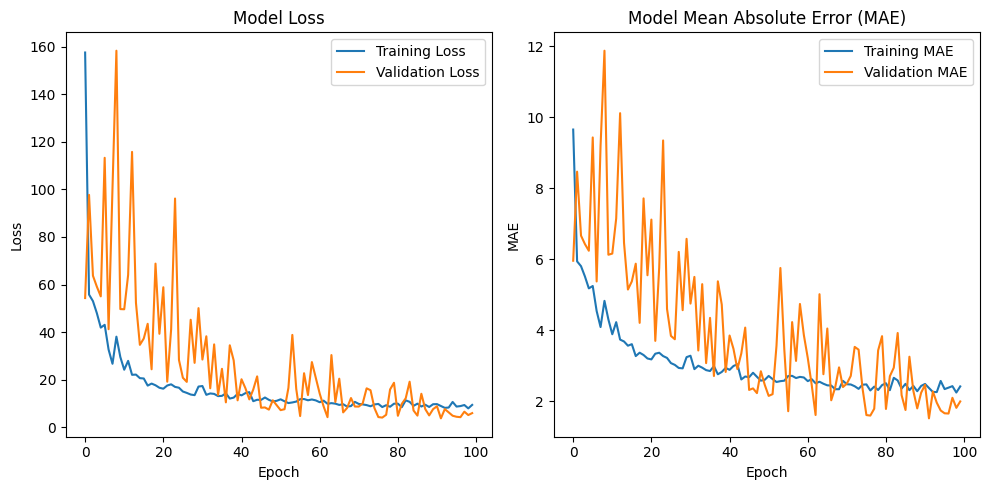

In [72]:
# Plot training & validation loss values
plt.figure( figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

The oscillating loss and MAE could be indicative that the learning rate was too high on this training.

## Evaluating Test Set

In [73]:
results = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE
    # steps ensures the generator covers the whole dataset exactly
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 4.9407 - mae: 1.6924


In [74]:
test_loss = results[0] # This is the Mean Squared Error (MSE)
test_mae = results[1]  # This is the Mean Absolute Error (MAE)

In [77]:
print(f'Loss for the test dataset = {round(test_loss, 3)}')
print(f'Mean Absolute Error for the test dataset = {round(test_mae,3)}')

Loss for the test dataset = 4.958
Mean Absolute Error for the test dataset = 1.71


## Demo

In [87]:
img_id = df.id.iloc[0]
label = df['count'].iloc[0]
img_path = get_img_path(img_id, imgs_folder)

In [90]:
example_img = load_img(img_path)

(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

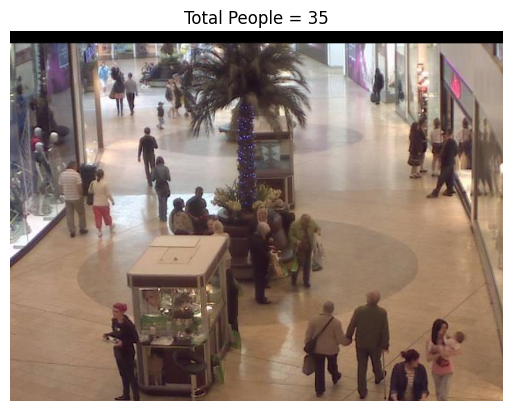

In [92]:
plt.imshow(example_img)
plt.title(f'Total People = {label}')
plt.axis('off')

In [93]:
preprocess_img = manual_img_preprocessing(img_path)
prediction_result = model.predict(preprocess_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


In [95]:
prediction_result

array([[30.05679]], dtype=float32)

In [96]:
final_result = int(round(prediction_result[0][0]))

(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

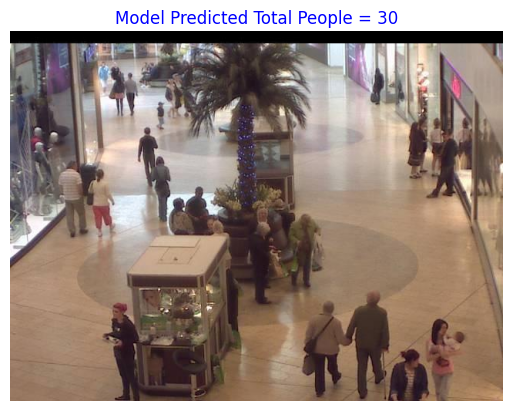

In [98]:
plt.imshow(example_img)
plt.title(f'Model Predicted Total People = {final_result}', color = 'blue')
plt.axis('off')

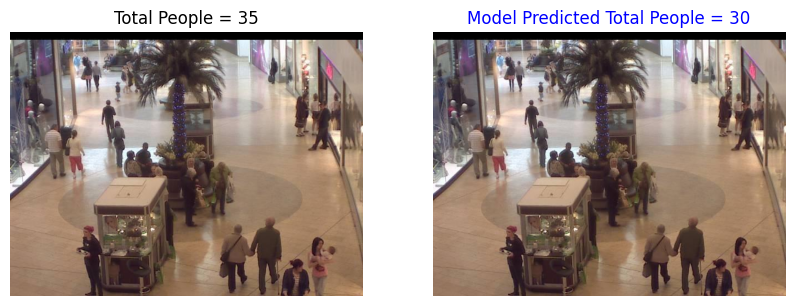

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(example_img)
ax[0].set_title(f'Total People = {label}')
ax[0].set_axis_off()


ax[1].imshow(example_img)
ax[1].set_title(f'Model Predicted Total People = {final_result}', color = 'blue')
ax[1].set_axis_off()